In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, SelectKBest, chi2
import statsmodels.api as sm
import numpy as np
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv (r'data_clean_4_21.csv')

## Data sources:
USDA Rural-Urban Continuum Codes    
https://www.ers.usda.gov/data-products/rural-urban-continuum-codes.aspx   
US census income and poverty data   
https://www.census.gov/data/tables/2019/demo/income-poverty/p60-266.html   
Covid-19 health system capacity   
https://github.com/covidcaremap/covid19-healthsystemcapacity/tree/master/data       
NY times covid-19 cases/deaths count   
https://github.com/nytimes/covid-19-data      
There are some reported cases/deaths in unknown/unavailable counties areas.

## Exploratory Analysis

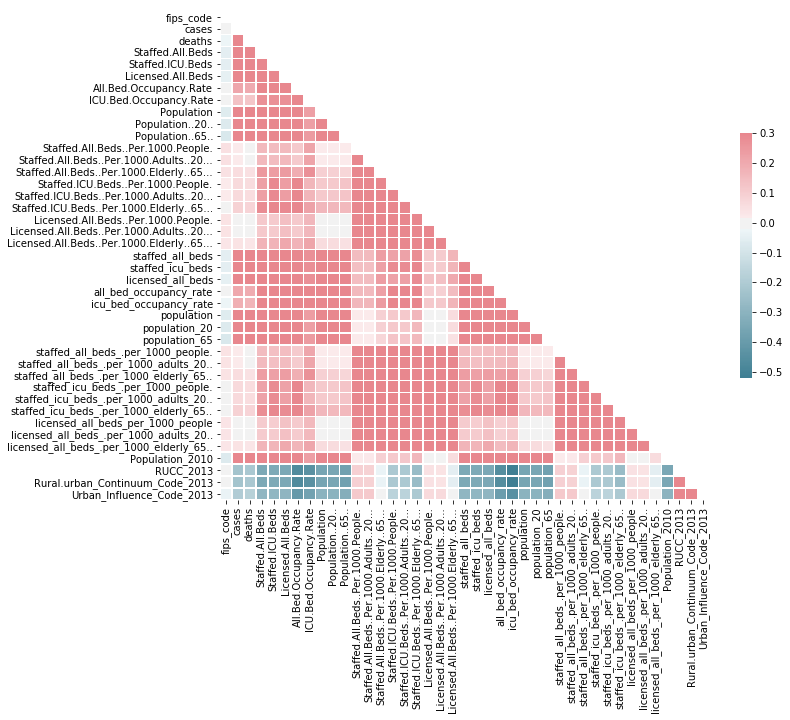

In [3]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [4]:
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    for x in unique_list: 
        print (x)

Top 25 counties with most cases and deaths distributed in the following states: 

In [5]:
data1 = data[['cases', 'deaths', 'state', 'county_x']]
top = data1.sort_values(['cases', 'deaths'], ascending=False).head(30)
unique(list(top['state']))

New York
Illinois
California
Michigan
New Jersey
Florida
Pennsylvania
Massachusetts
Connecticut
Louisiana
Washington
Texas


Top states with most cases and deaths across all counties:

In [ ]:
data1.groupby(['state']).sum().sort_values(['cases', 'deaths'], ascending=False).head(11)

In [ ]:
groups = top.groupby("state")
for name, group in groups:
    plt.plot(group["cases"], group["deaths"], marker="o", linestyle="", label=name)
plt.legend(loc='best', bbox_to_anchor=(0.9, 0., 0.5, 0.8))
plt.title('Top 25 counties with most cases/deaths by state')
plt.xlabel('cases')
plt.ylabel('deathes')

## Methods
1. Model capability using multiple linear regression.  
2. Apply multivariate bootstrap techniques with hypothesis testing for model selection.  
3. Clustering (hierarchical clustering) for capability classification based on US regions. 

## 1. Feature Selection
Before conducting regression, we did performed feature selection with stepwise selection and random forest. 

In [6]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [7]:
# remove those without fips_code
data.dropna(subset = ["fips_code"], inplace=True)
data.dropna(subset = ["ICU.Bed.Occupancy.Rate"], inplace=True)
data.dropna(subset = ["population_20"], inplace=True)
#data.isnull().sum()

In [13]:
X = data.drop(['fips_code', 'date', 'county', 'State', 'Staffed.All.Beds', 'Staffed.ICU.Beds', 'Licensed.All.Beds',
       'All.Bed.Occupancy.Rate', 'ICU.Bed.Occupancy.Rate', 'Population', 'Population_2010',
       'Population..20..', 'Population..65..',
       'Staffed.All.Beds..Per.1000.People.',
       'Staffed.All.Beds..Per.1000.Adults..20...',
       'Staffed.All.Beds..Per.1000.Elderly..65...',
       'Staffed.ICU.Beds..Per.1000.People.',
       'Staffed.ICU.Beds..Per.1000.Adults..20...',
       'Staffed.ICU.Beds..Per.1000.Elderly..65...',
       'Licensed.All.Beds..Per.1000.People.',
       'Licensed.All.Beds..Per.1000.Adults..20...',
       'Licensed.All.Beds..Per.1000.Elderly..65...', 'county_x', 'cases', 'deaths', 'County_Name', 'Area_name'], axis = 1)
X['state'] = X.state.factorize()[0]
X['Description'] = X.Description.factorize()[0]
X['peopleinpoverty2018'] = X.peopleinpoverty2018.factorize()[0]
X['medianhouseholdincome'] = X.medianhouseholdincome.factorize()[0]
Y_c = data['cases']
Y_d = data['deaths']

In [9]:
X.columns

Index(['state', 'staffed_all_beds', 'staffed_icu_beds', 'licensed_all_beds',
       'all_bed_occupancy_rate', 'icu_bed_occupancy_rate', 'population',
       'population_20', 'population_65', 'staffed_all_beds_.per_1000_people.',
       'staffed_all_beds_.per_1000_adults_20..',
       'staffed_all_beds_.per_1000_elderly_65..',
       'staffed_icu_beds_.per_1000_people.',
       'staffed_icu_beds_.per_1000_adults_20..',
       'staffed_icu_beds_.per_1000_elderly_65..',
       'licensed_all_beds_per_1000_people',
       'licensed_all_beds_.per_1000_adults_20..',
       'licensed_all_beds_.per_1000_elderly_65..', 'RUCC_2013', 'Description',
       'Rural.urban_Continuum_Code_2013', 'Urban_Influence_Code_2013',
       'peopleinpoverty2018', 'medianhouseholdincome'],
      dtype='object')

In [10]:
# for predicting cases
result = stepwise_selection(X, Y_c)
print('resulting features:')
print(result)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Add  population_65                  with p-value 9.47915e-120
Add  population                     with p-value 0.00326538
Add  licensed_all_beds              with p-value 1.66385e-05
Add  population_20                  with p-value 0.00188185
Add  staffed_all_beds               with p-value 0.00311882
resulting features:
['population_65', 'population', 'licensed_all_beds', 'population_20', 'staffed_all_beds']


In [11]:
# for predicting deaths
result = stepwise_selection(X, Y_d)
print('resulting features:')
print(result)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Add  population_65                  with p-value 1.3761e-94
Add  population                     with p-value 1.83961e-06
Add  licensed_all_beds              with p-value 0.0017707
Add  staffed_all_beds               with p-value 0.00249271
resulting features:
['population_65', 'population', 'licensed_all_beds', 'staffed_all_beds']


In [ ]:
#fit = ols('cases ~ C(state) + population + licensed_all_beds + population_65 + staffed_all_beds + population_20 + licensed_all_beds_per_1000_people', data = data).fit()
#fit.summary()

In [14]:
# for predicting cases
X_train, X_valid, y_train, y_valid = train_test_split(X, Y_c, test_size = 0.7, random_state = 1)
rf = RandomForestClassifier() 
rf.fit(X_train, y_train) 
rf.score(X_valid, y_valid)
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances[0:6]

,importance
population,0.051609
population_20,0.051589
population_65,0.051393
all_bed_occupancy_rate,0.049998
peopleinpoverty2018,0.049781
icu_bed_occupancy_rate,0.049600


In [15]:
# for predicting deaths
X_train, X_valid, y_train, y_valid = train_test_split(X, Y_d, test_size = 0.7, random_state = 1)
rf = RandomForestClassifier() 
rf.fit(X_train, y_train) 
rf.score(X_valid, y_valid)
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances[0:5]

,importance
population_20,0.061946
population,0.059339
population_65,0.057003
icu_bed_occupancy_rate,0.054854
all_bed_occupancy_rate,0.051577


## 2.1 Regression with stepwise selection

In [ ]:
data.columns = data.columns.str.strip().str.lower().str.replace('.', '_').str.replace('(', '').str.replace(')', '')

In [ ]:
# predicting cases
fit = ols('cases ~ population_65 + population__65__ + population + population_2010 + population + licensed_all_beds + staffed_all_beds + licensed_all_beds + staffed_all_beds + staffed_icu_beds + all_bed_occupancy_rate + staffed_icu_beds + description + urban_influence_code_2013', data = data).fit()
fit.summary()

In [ ]:
# predicted deaths
fit = ols('deaths ~ population_65 + population__65__ + population + population_2010 + population + all_bed_occupancy_rate + all_bed_occupancy_rate', data = data).fit()
fit.summary()

## 2.2 Ensemble learning model
1. K-NN
2. Random Forest
3. Logistic regression

In [16]:
X_c = X[['population_65', 'icu_bed_occupancy_rate', 'medianhouseholdincome', 'all_bed_occupancy_rate', 'peopleinpoverty2018']]


X_train, X_test, y_train, y_test = train_test_split(X_c, Y_c, test_size=0.7)

K-nn

In [19]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(X_train, y_train)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [20]:
#save best model
knn_best = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)

{'n_neighbors': 11}


Random forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(X_train, y_train)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [22]:
#save best model
rf_best = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)

{'n_estimators': 100}


logistic regression

In [23]:
from sklearn.linear_model import LogisticRegression
#create a new logistic regression model
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(X_train, y_train)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
print('knn: {}'.format(knn_best.score(X_test, y_test)))
print('rf: {}'.format(rf_best.score(X_test, y_test)))
print('log_reg: {}'.format(log_reg.score(X_test, y_test)))

knn: 0.023036649214659685
rf: 0.015706806282722512
log_reg: 0.023036649214659685


predicting deaths

In [ ]:
X.columns

In [ ]:
X.columns

In [25]:
X_c = X[['population_65', 'icu_bed_occupancy_rate', 'all_bed_occupancy_rate', 'peopleinpoverty2018']]



#X_train, X_test, y_train, y_test = train_test_split(X_d, Y_d, test_size=0.3)

In [26]:
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(X_train, y_train)
#save best model
knn_best = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)
#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(X_train, y_train)
#save best model
rf_best = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)
#create a new logistic regression model
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(X_train, y_train)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'n_neighbors': 11}


/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'n_estimators': 200}


/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
print('knn: {}'.format(knn_best.score(X_test, y_test)))
print('rf: {}'.format(rf_best.score(X_test, y_test)))
print('log_reg: {}'.format(log_reg.score(X_test, y_test)))

knn: 0.023036649214659685
rf: 0.016753926701570682
log_reg: 0.023036649214659685


## 2.3 Regression without population data

In [28]:
X_new = X.drop(['population'], axis = 1)

In [29]:
X_new.columns

Index(['state', 'staffed_all_beds', 'staffed_icu_beds', 'licensed_all_beds',
       'all_bed_occupancy_rate', 'icu_bed_occupancy_rate', 'population_20',
       'population_65', 'staffed_all_beds_.per_1000_people.',
       'staffed_all_beds_.per_1000_adults_20..',
       'staffed_all_beds_.per_1000_elderly_65..',
       'staffed_icu_beds_.per_1000_people.',
       'staffed_icu_beds_.per_1000_adults_20..',
       'staffed_icu_beds_.per_1000_elderly_65..',
       'licensed_all_beds_per_1000_people',
       'licensed_all_beds_.per_1000_adults_20..',
       'licensed_all_beds_.per_1000_elderly_65..', 'RUCC_2013', 'Description',
       'Rural.urban_Continuum_Code_2013', 'Urban_Influence_Code_2013',
       'peopleinpoverty2018', 'medianhouseholdincome'],
      dtype='object')

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X_new, Y_d, test_size = 0.7, random_state = 1)
rf = RandomForestClassifier() 
rf.fit(X_train, y_train) 
rf.score(X_valid, y_valid)
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
population_20,0.064114
population_65,0.062464
icu_bed_occupancy_rate,0.056352
staffed_all_beds,0.056023
all_bed_occupancy_rate,0.055298
licensed_all_beds,0.052179
staffed_icu_beds,0.049379
staffed_icu_beds_.per_1000_elderly_65..,0.047451
medianhouseholdincome,0.046945
peopleinpoverty2018,0.046697


In [31]:
X_d = X[['population_20', 'population_65', 'icu_bed_occupancy_rate', 'licensed_all_beds', 'all_bed_occupancy_rate']]


X_train, X_test, y_train, y_test = train_test_split(X_d, Y_d, test_size=0.3)

In [32]:
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(X_train, y_train)
#save best model
knn_best = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)
#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(X_train, y_train)
#save best model
rf_best = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)
#create a new logistic regression model
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(X_train, y_train)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'n_neighbors': 24}


/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'n_estimators': 100}


/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
print('knn: {}'.format(knn_best.score(X_test, y_test)))
print('rf: {}'.format(rf_best.score(X_test, y_test)))
print('log_reg: {}'.format(log_reg.score(X_test, y_test)))

knn: 0.33170731707317075
rf: 0.32682926829268294
log_reg: 0.32439024390243903


In [34]:
#voting classifier
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('knn', knn_best), ('rf', rf_best), ('log_reg', log_reg)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')
#fit model to training data
ensemble.fit(X_train, y_train)
#test our model on the test data
ensemble.score(X_test, y_test)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.33658536585365856

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

In [39]:
gbrt = GradientBoostingRegressor(max_depth=5, 
                                 n_estimators=3, 
                                 learning_rate=1.0)
gbrt.fit(X_d, Y_d)
gbrt.score(X_d, Y_d)
mse = mean_squared_error(y_test, gbrt.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 324.7722


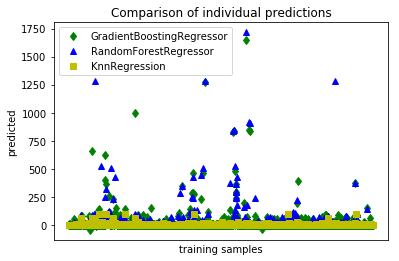

In [48]:
plt.figure()
plt.plot(gbrt.predict(X_d), 'gd', label='GradientBoostingRegressor')
plt.plot(rf_best.predict(X_d), 'b^', label='RandomForestRegressor')
plt.plot(knn_best.predict(X_d), 'ys', label='KnnRegression')
#plt.plot(clf.predict(X_d), 'r*', label='MLP')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions')
plt.show()

## 2.4 Neural Network regression (Multi-layer Perceptron)

In [44]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_d, Y_d)
MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

## 3. Clustering with selected features

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
X_d

In [ ]:
# for predicting cases
#X_c = X[['population_65', 'licensed_all_beds', 'staffed_all_beds', 'Licensed.All.Beds', 'Staffed.All.Beds', 'Staffed.ICU.Beds', 'All.Bed.Occupancy.Rate', 'staffed_icu_beds', 'Description', 'Urban_Influence_Code_2013']]
X_cases = StandardScaler().fit_transform(X_d)
X_cases

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_cases)
kmeans
y_hat = kmeans.predict(X_cases)
y_hat

In [ ]:
#for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples to the nearest cluster centre
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X_c)
    sum_of_squared_distances.append(k_means.inertia_)
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k - predicting cases')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X_cases)
kmeans
labels = kmeans.predict(X_cases)
centroids = kmeans.cluster_centers_

Visualize data clustered closely together, the black triangle represents the centroid. 

In [ ]:
plt.scatter(X_cases[:,0], X_cases[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], marker='^', color='k')

In [ ]:
plt.scatter(X_cases[:, 0], X_cases[:, 1], c=labels, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [ ]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X_cases, 4)
plt.scatter(X_cases[:, 0], X_cases[:, 1], c=labels,
            s=50, cmap='viridis');

In [ ]:
labels = kmeans.predict

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_X_cases = pca.fit_transform(X_cases)
pca.explained_variance_ratio_

In [ ]:
Y_d

In [ ]:
Y_c

In [ ]:
Yd_q = pd.qcut(Y_d, q=5, retbins=False, duplicates='drop')
#  dtype = CategoricalDtype(categories=['UNDER $1 000', '$1 000 TO 2 999', '$3 000 TO 3 999',
#                                      '$90000 - $109999', '$110000 OR OVER', 'REFUSED'],
#                          ordered=True)
# Yc_q.cat.reorder_categories(category[::-1])
# Yc_q_ = CategoricalDtype(categories=dtype.categories[::-1], ordered=True)

In [ ]:
Yd_q

In [ ]:
cases_df = pd.DataFrame()
cases_df['pca_1'] = pca_X_cases[:,0]
cases_df['pca_2'] = pca_X_cases[:,1]
cases_df['cluster_id'] = y_hat
cases_df['deaths'] = Yd_q
plt.figure(figsize=(15,10))
sns.scatterplot(x='pca_1',y='pca_2',size='deaths',hue='cluster_id',data=cases_df)

In [ ]:
# feature selection -> K-Means algorithm -> Visualzaition 
# Viz: radis: # death, color: cluster_id find correlation??
#